In [22]:
import numpy as np
import matplotlib.pyplot as plt
import find_alpha
import torch

Реализуем второй метод для нахождения оптимального $\alpha$: минимизация обобщённой невязки

С известной $\sigma$

In [23]:
f_0 = 300
mu = 8e5
a = 0
b = 1e-2
N = 100
t_ax = np.linspace(a,b,N)

x_t = lambda t : np.cos(2 * np.pi * f_0 * t + mu * t**2)

beta = 3e3
A = 0.5
dt = 2e-3

kernel = lambda t : np.exp(- beta * t) + A * np.exp(- beta * t - dt)

In [24]:
f_t = find_alpha.conv(kernel, x_t, t_ax)

In [25]:
#Фурье от правой части:
kernel_ar = kernel(t_ax)
kernel_fft = np.fft.fft(kernel_ar)
m_omega = lambda omega: omega ** 2 + 1e-4
freq_ax = np.fft.fftfreq(len(t_ax), t_ax[1] - t_ax[0])
m_ar = m_omega(freq_ax)

In [26]:
epoch_num = 1000
alpha_opt = np.zeros(epoch_num)

In [27]:
sig_1 = np.load('../30_9/sec_meth_1_e_1.npy')
sig_2 = np.load('../30_9/sec_meth_7_e_2_n.npy')

Text(0, 0.5, 'frequency')

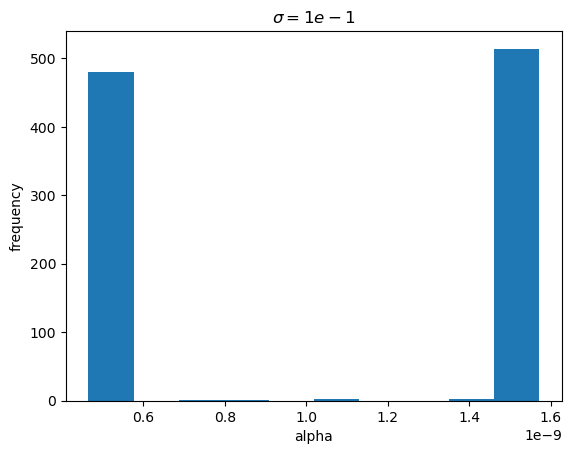

In [28]:
plt.hist(sig_1)
plt.title('$\sigma = 1e-1$')
plt.xlabel('alpha')
plt.ylabel('frequency')

Text(0, 0.5, 'frequency')

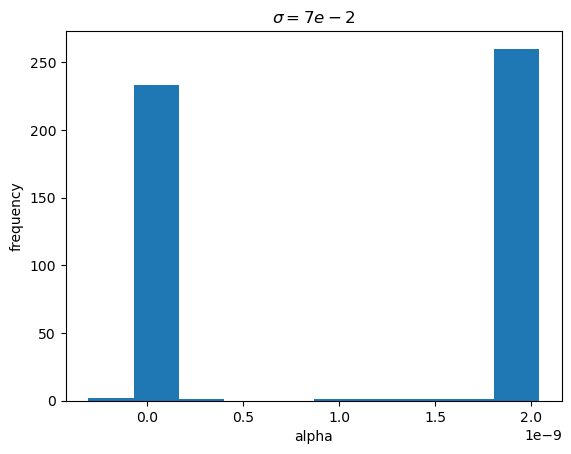

In [29]:
plt.hist(sig_2)
plt.title('$\sigma = 7e-2$')
plt.xlabel('alpha')
plt.ylabel('frequency')

Для $\sigma = 7e-2$ сместим оценку вверх и вниз на 20% и посмотрим на гистограммы частот

In [30]:
sig_high = np.load('../30_9/sec_meth_7_e_2_high.npy')
sig_low = np.load('../30_9/sec_meth_7_e_2_low.npy')

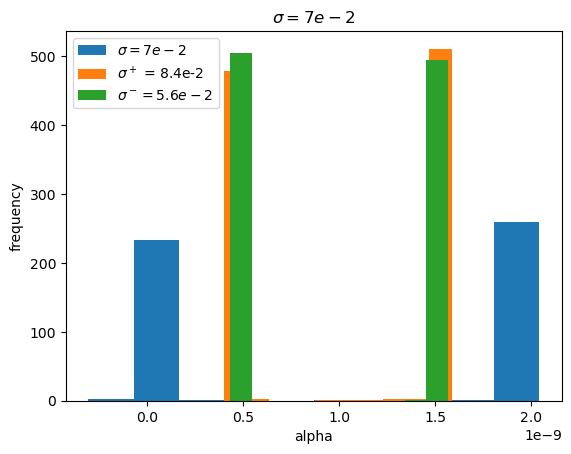

In [31]:
plt.hist(sig_2, label='$\sigma = 7e-2$')
plt.hist(sig_high, label='$\sigma^+$ = 8.4e-2')
plt.hist(sig_low, label='$\sigma^- = 5.6e-2$')
plt.title('$\sigma = 7e-2$')
plt.xlabel('alpha')
plt.ylabel('frequency')
plt.legend()

Построим график